**Importing libraries**

In [156]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, fcluster , dendrogram
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

**Loading the datasets**

In [157]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

# Merge Datasets and Validate Data

In [158]:
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
customer_tenure = (transactions['TransactionDate'].max() - transactions.groupby('CustomerID')['TransactionDate'].min()).dt.days
monthly_transactions = transactions.groupby(['CustomerID', transactions['TransactionDate'].dt.to_period('M')])['TransactionID'].count().unstack(fill_value=0)

# Merge data
customer_data = pd.merge(customers,
                          transactions.groupby('CustomerID').agg(
                              total_spent=('TotalValue', 'sum'),
                              total_transactions=('TransactionID', 'count')
                          ).reset_index(),
                          on='CustomerID', how='left').fillna(0)

customer_data = pd.merge(customer_data, customer_tenure.rename('CustomerTenure'), on='CustomerID', how='left')
customer_data = pd.merge(customer_data, monthly_transactions.sum(axis=1).rename('MonthlyTransactionFrequency'), on='CustomerID', how='left')

# Feature Engineering , Encode and normalize features

In [159]:
customer_data['Region'] = LabelEncoder().fit_transform(customer_data['Region'])
features = customer_data[['Region', 'total_spent', 'total_transactions', 'CustomerTenure', 'MonthlyTransactionFrequency']]

# Impute missing values using the mean
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)

# Scale the imputed data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

**Determine Optimal Clusters with KMeans**

In [160]:
optimal_k, db_indexes_kmeans = 2, []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(features_scaled)
    db_indexes_kmeans.append(davies_bouldin_score(features_scaled, kmeans.labels_))
    if db_indexes_kmeans[-1] == min(db_indexes_kmeans):
        optimal_k = k

# Apply KMeans
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42).fit(features_scaled)
customer_data['KMeans_Cluster'] = kmeans_final.labels_

**DBSCAN**

In [161]:
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(features_scaled)
customer_data['DBSCAN_Cluster'] = dbscan.labels_


**Gaussian Mixture Model**

In [162]:
gmm = GaussianMixture(n_components=optimal_k, random_state=42).fit(features_scaled)
customer_data['GMM_Cluster'] = gmm.predict(features_scaled)

**Hierarchical Clustering**

In [163]:
linkage_matrix = linkage(features_scaled, method='ward')
customer_data['Hierarchical_Cluster'] = fcluster(linkage_matrix, t=optimal_k, criterion='maxclust')

#  Evaluate Metrics

In [164]:
# KMeans Metrics
kmeans_db_index = davies_bouldin_score(features_scaled, customer_data['KMeans_Cluster'])
kmeans_silhouette = silhouette_score(features_scaled, customer_data['KMeans_Cluster'])

# GMM Metrics
gmm_db_index = davies_bouldin_score(features_scaled, customer_data['GMM_Cluster'])
gmm_silhouette = silhouette_score(features_scaled, customer_data['GMM_Cluster'])

# DBSCAN Metrics
dbscan_clusters = customer_data['DBSCAN_Cluster'].unique()
dbscan_db_index = davies_bouldin_score(features_scaled, customer_data['DBSCAN_Cluster']) if len(dbscan_clusters) > 1 else None
dbscan_silhouette = silhouette_score(features_scaled, customer_data['DBSCAN_Cluster']) if len(dbscan_clusters) > 1 else None

**Print Comparisons**

In [165]:
print(f"KMeans - DB Index: {kmeans_db_index}, Silhouette Score: {kmeans_silhouette}")
print(f"GMM - DB Index: {gmm_db_index}, Silhouette Score: {gmm_silhouette}")
print(f"DBSCAN - DB Index: {dbscan_db_index}, Silhouette Score: {dbscan_silhouette}")

KMeans - DB Index: 1.0898012620358515, Silhouette Score: 0.26545823590673634
GMM - DB Index: 1.1818002373857772, Silhouette Score: 0.19784178943848693
DBSCAN - DB Index: 1.8180140074350104, Silhouette Score: -0.2582631114428935


# Visualizations

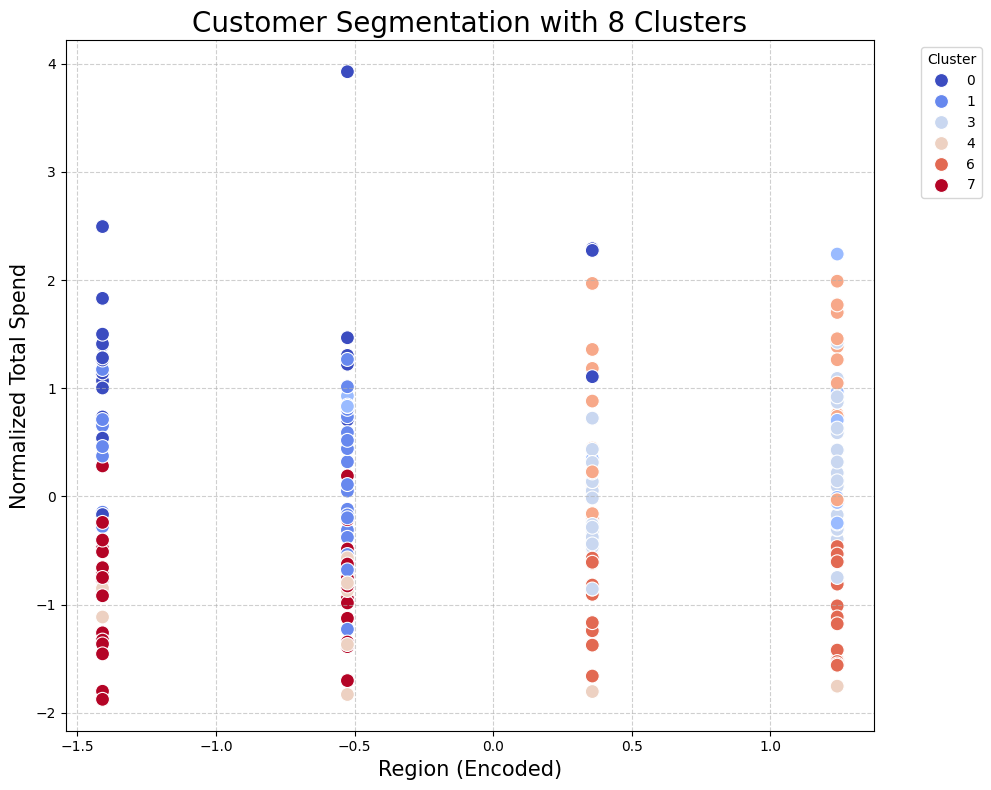

In [166]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=features_scaled[:, 0], y=features_scaled[:, 1], hue=customer_data['KMeans_Cluster'], palette="coolwarm", s=100, edgecolor="white"
)
plt.title(f"Customer Segmentation with {optimal_k} Clusters", fontsize=20)
plt.xlabel("Region (Encoded)", fontsize=15)
plt.ylabel("Normalized Total Spend", fontsize=15)
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**3D Visualization for GMM**

In [167]:
fig = px.scatter_3d(customer_data,
                    x=features_scaled[:, 0], y=features_scaled[:, 1], z=features_scaled[:, 2],
                    color=customer_data['GMM_Cluster'].astype(str),
                    title="3D Clustering Visualization (GMM)",
                    labels={'x': 'Feature 1', 'y': 'Feature 2', 'z': 'Feature 3'})
fig.show()

**Dendrogram for Hierarchical Clustering**

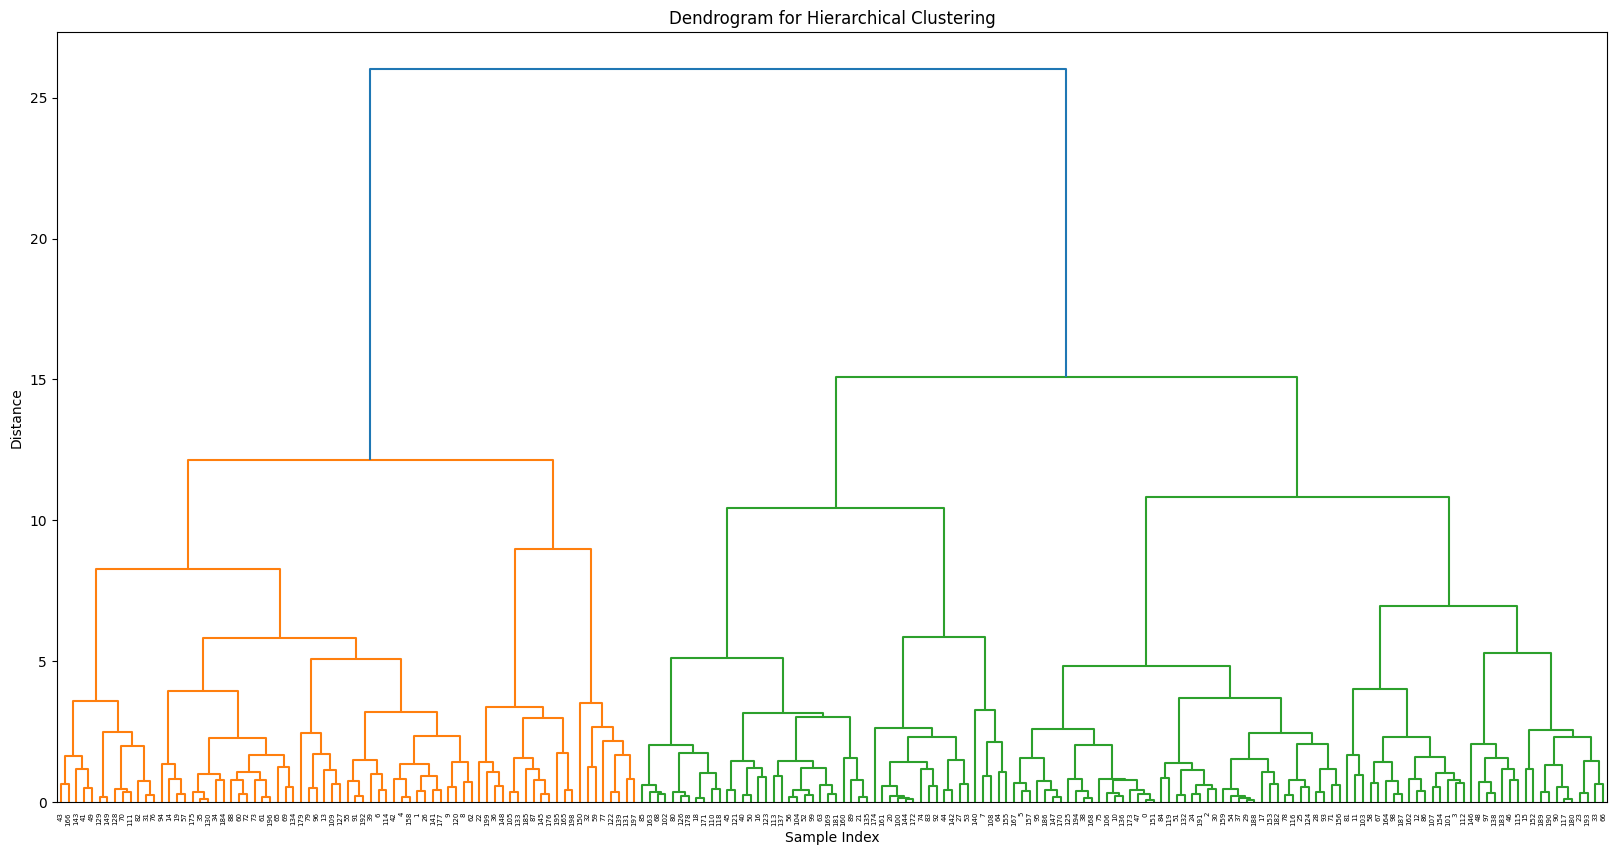

In [168]:
plt.figure(figsize=(20,10))
dendrogram(linkage_matrix)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

**DB Index Plot for KMeans**

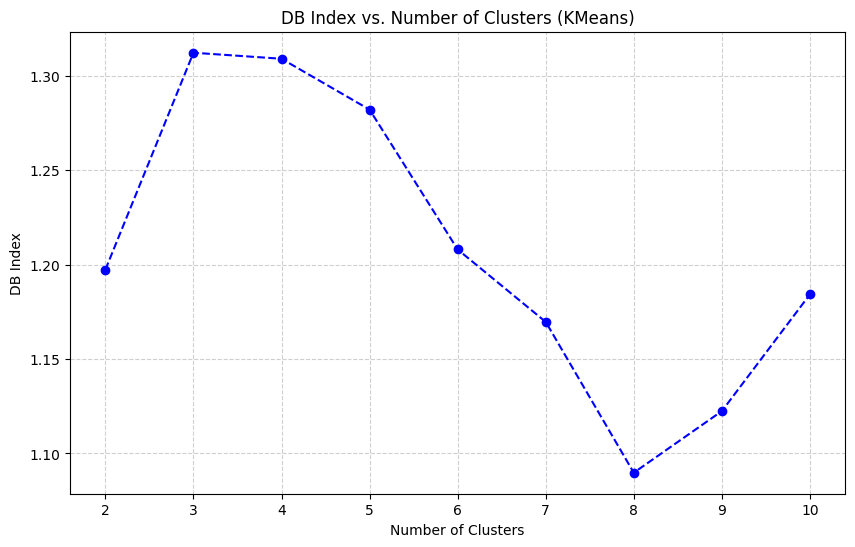

In [169]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), db_indexes_kmeans, marker='o', linestyle='--', color='b')
plt.title("DB Index vs. Number of Clusters (KMeans)")
plt.xlabel("Number of Clusters")
plt.ylabel("DB Index")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [170]:
# Step 7: Save Results
customer_data.to_csv("Customer_Segmentation.csv", index=False)
print("Customer segmentation results saved successfully.")

Customer segmentation results saved successfully.
